In [2]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [3]:
# read the data
dataset = pd.read_csv('20_year_FD.csv')
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount,label
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,1111793.167,False
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,394141.216,True
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,446597.972,True
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,164467.462,False
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,180573.596,False


In [4]:
dataset['label'] = dataset['pre_close']<dataset['close']
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,amount,label
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,1111793.167,False
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,394141.216,False
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,446597.972,True
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,164467.462,False
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,180573.596,False


In [5]:
import talib as ta
types=['SMA','EMA','WMA','DEMA','TEMA',
'TRIMA','KAMA','MAMA','T3']
for i in range(len(types)):
    dataset[types[i]]=ta.MA(dataset.close.to_numpy(),timeperiod=10,matype=i)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,label,SMA,EMA,WMA,DEMA,TEMA,TRIMA,KAMA,MAMA,T3
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,False,3.5190,3.504778,3.514382,3.513304,3.498623,3.528200,3.461945,3.502220,3.529209
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,False,3.5149,3.495909,3.502927,3.495628,3.476412,3.523200,3.461833,3.499909,3.528766
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,False,3.5021,3.483744,3.487309,3.473561,3.449736,3.513033,3.458546,3.492094,3.524939
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,True,3.5009,3.479609,3.479836,3.467894,3.447148,3.501667,3.458567,3.476547,3.518941


In [6]:
import talib as ta
def add_MA(timeperiod,df):
    types=['SMA','EMA','WMA','DEMA','TEMA',
    'TRIMA','KAMA','MAMA','T3']
    types = [i+'_'+str(timeperiod) for i in types]
    for i in range(len(types)):
        df[types[i]]=ta.MA(df.close.to_numpy(),timeperiod=timeperiod,matype=i)
    return df

In [7]:
dataset = add_MA(5,dataset)
dataset = add_MA(10,dataset)
dataset = add_MA(30,dataset)
dataset.head()

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,T3_10,SMA_30,EMA_30,WMA_30,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

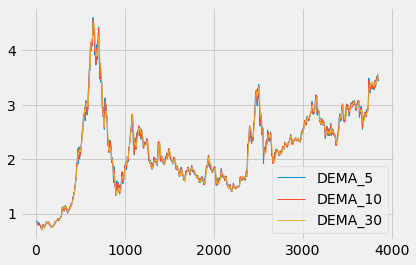

In [8]:
dataset[["DEMA_5","DEMA_10","DEMA_30"]].plot(linewidth=1)

In [9]:
#布林带计算
H_line,M_line,L_line=ta.BBANDS(dataset.close.to_numpy(), timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
dataset['H_line']=H_line
dataset['M_line']=M_line
dataset['L_line']=L_line
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,WMA_30,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.486903,3.520700,3.528665,3.462479,3.397633,3.502220,3.449538,3.582138,3.5190,3.455862
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.486830,3.515788,3.519381,3.468629,3.398405,3.499909,3.454124,3.587791,3.5149,3.442009
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.484858,3.507868,3.506141,3.474308,3.398969,3.492094,3.458540,3.585168,3.5021,3.419032
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.484735,3.504605,3.500176,3.479171,3.400656,3.476547,3.462743,3.585939,3.5009,3.415861


<AxesSubplot:>

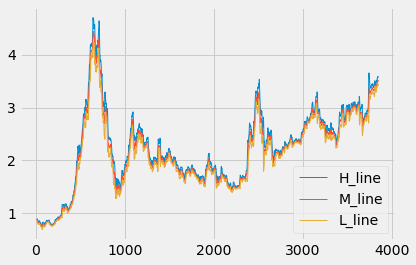

In [10]:
dataset[['H_line','M_line','L_line']].plot(linewidth=1)

In [11]:
#希尔伯特瞬时变换
dataset['ht_trendline'] = ta.HT_TRENDLINE(dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,DEMA_30,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.520700,3.528665,3.462479,3.397633,3.502220,3.449538,3.582138,3.5190,3.455862,3.498419
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.515788,3.519381,3.468629,3.398405,3.499909,3.454124,3.587791,3.5149,3.442009,3.499730
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.507868,3.506141,3.474308,3.398969,3.492094,3.458540,3.585168,3.5021,3.419032,3.499715
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.504605,3.500176,3.479171,3.400656,3.476547,3.462743,3.585939,3.5009,3.415861,3.498475


In [12]:
dataset['midpoint'] = ta.MIDPOINT(dataset.close.to_numpy(), timeperiod=14)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,TEMA_30,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.528665,3.462479,3.397633,3.502220,3.449538,3.582138,3.5190,3.455862,3.498419,3.5110
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.519381,3.468629,3.398405,3.499909,3.454124,3.587791,3.5149,3.442009,3.499730,3.5065
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.506141,3.474308,3.398969,3.492094,3.458540,3.585168,3.5021,3.419032,3.499715,3.4930
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.500176,3.479171,3.400656,3.476547,3.462743,3.585939,3.5009,3.415861,3.498475,3.4930


In [13]:
dataset['midprice'] = ta.MIDPRICE(dataset.high.to_numpy(), dataset.low.to_numpy(), timeperiod=14)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,TRIMA_30,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.462479,3.397633,3.502220,3.449538,3.582138,3.5190,3.455862,3.498419,3.5110,3.5125
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.468629,3.398405,3.499909,3.454124,3.587791,3.5149,3.442009,3.499730,3.5065,3.5095
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.474308,3.398969,3.492094,3.458540,3.585168,3.5021,3.419032,3.499715,3.4930,3.4915
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.479171,3.400656,3.476547,3.462743,3.585939,3.5009,3.415861,3.498475,3.4930,3.4915


In [14]:
dataset['sar'] = ta.SAR(dataset.high.to_numpy(), dataset.low.to_numpy(), acceleration=0, maximum=0)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,KAMA_30,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice,sar
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.397633,3.502220,3.449538,3.582138,3.5190,3.455862,3.498419,3.5110,3.5125,0.700
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.398405,3.499909,3.454124,3.587791,3.5149,3.442009,3.499730,3.5065,3.5095,0.700
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.398969,3.492094,3.458540,3.585168,3.5021,3.419032,3.499715,3.4930,3.4915,0.700
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.400656,3.476547,3.462743,3.585939,3.5009,3.415861,3.498475,3.4930,3.4915,0.700


In [15]:
dataset['sarext'] = ta.SAREXT(dataset.high.to_numpy(), dataset.low.to_numpy(), startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,MAMA_30,T3_30,H_line,M_line,L_line,ht_trendline,midpoint,midprice,sar,sarext
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866,0.866
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.887,-0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.502220,3.449538,3.582138,3.5190,3.455862,3.498419,3.5110,3.5125,0.700,0.700
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.499909,3.454124,3.587791,3.5149,3.442009,3.499730,3.5065,3.5095,0.700,0.700
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.492094,3.458540,3.585168,3.5021,3.419032,3.499715,3.4930,3.4915,0.700,0.700
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.476547,3.462743,3.585939,3.5009,3.415861,3.498475,3.4930,3.4915,0.700,0.700


In [16]:
#加入动量指标
dataset['cci'] = ta.CCI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
dataset['cmo'] = ta.CMO(dataset.close.to_numpy(), timeperiod=14)
dataset['dx'] = ta.DX(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(dataset.close.to_numpy(), fastperiod=12, slowperiod=26, signalperiod=9)
dataset['macd'] = macd
dataset['macdsignal'] = macdsignal
dataset['macdhist'] = macdhist
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,midpoint,midprice,sar,sarext,cci,cmo,dx,macd,macdsignal,macdhist
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,0.866,0.866,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,0.887,-0.887,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.5110,3.5125,0.700,0.700,-87.538941,-0.994947,14.862795,0.026648,0.032072,-0.005424
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.5065,3.5095,0.700,0.700,-176.334107,-4.536311,4.477551,0.020982,0.029854,-0.008872
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.4930,3.4915,0.700,0.700,-179.619398,-11.137925,7.934613,0.014150,0.026713,-0.012564
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.4930,3.4915,0.700,0.700,-111.367232,-2.124064,7.934613,0.011188,0.023608,-0.012420


<AxesSubplot:>

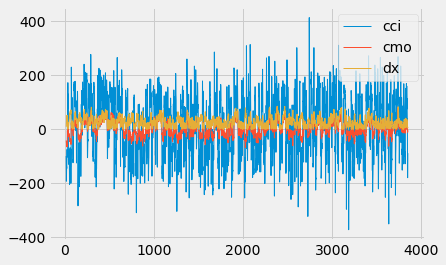

In [17]:
dataset[['cci','cmo','dx']].plot(linewidth=1)

In [18]:
dataset['mfi'] = ta.MFI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), dataset.vol.to_numpy(), timeperiod=14)
dataset['minus_di'] = ta.MINUS_DI(dataset.high.to_numpy(), dataset.low.to_numpy(), dataset.close.to_numpy(), timeperiod=14)
dataset['minus_dm'] = ta.MINUS_DM(dataset.high.to_numpy(), dataset.low.to_numpy(), timeperiod=14)
dataset['mom'] = ta.MOM(dataset.close.to_numpy(),timeperiod=10)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cci,cmo,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,-87.538941,-0.994947,14.862795,0.026648,0.032072,-0.005424,45.981280,15.432946,0.119910,0.002
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,-176.334107,-4.536311,4.477551,0.020982,0.029854,-0.008872,41.560586,18.084189,0.137345,-0.041
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,-179.619398,-11.137925,7.934613,0.014150,0.026713,-0.012564,33.960221,20.959879,0.163534,-0.128
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,-111.367232,-2.124064,7.934613,0.011188,0.023608,-0.012420,39.301190,19.941467,0.151853,-0.012


### 成交量指标

In [19]:
dataset['AD'] = ta.AD(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),dataset.vol.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cmo,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,-0.994947,14.862795,0.026648,0.032072,-0.005424,45.981280,15.432946,0.119910,0.002,6.597106e+08
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,-4.536311,4.477551,0.020982,0.029854,-0.008872,41.560586,18.084189,0.137345,-0.041,6.592281e+08
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,-11.137925,7.934613,0.014150,0.026713,-0.012564,33.960221,20.959879,0.163534,-0.128,6.575701e+08
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,-2.124064,7.934613,0.011188,0.023608,-0.012420,39.301190,19.941467,0.151853,-0.012,6.597613e+08


In [20]:
dataset['ADOSC'] = ta.ADOSC(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),dataset.vol.to_numpy(),fastperiod=3, slowperiod=10)
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,dx,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD,ADOSC
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06,NaN
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06,NaN
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06,NaN
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,14.862795,0.026648,0.032072,-0.005424,45.981280,15.432946,0.119910,0.002,6.597106e+08,-2.484412e+06
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,4.477551,0.020982,0.029854,-0.008872,41.560586,18.084189,0.137345,-0.041,6.592281e+08,-3.111421e+06
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,7.934613,0.014150,0.026713,-0.012564,33.960221,20.959879,0.163534,-0.128,6.575701e+08,-3.612632e+06
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,7.934613,0.011188,0.023608,-0.012420,39.301190,19.941467,0.151853,-0.012,6.597613e+08,-2.792025e+06


In [21]:
dataset['OBV'] = ta.OBV(dataset.close.to_numpy(),dataset.vol.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,macd,macdsignal,macdhist,mfi,minus_di,minus_dm,mom,AD,ADOSC,OBV
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.174356e+06,NaN,1.269743e+07
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.690499e+06,NaN,1.269743e+07
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.846397e+06,NaN,1.776203e+07
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.802146e+06,NaN,1.588238e+07
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.761674e+06,NaN,1.380144e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,0.026648,0.032072,-0.005424,45.981280,15.432946,0.119910,0.002,6.597106e+08,-2.484412e+06,9.940283e+08
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,0.020982,0.029854,-0.008872,41.560586,18.084189,0.137345,-0.041,6.592281e+08,-3.111421e+06,9.894450e+08
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,0.014150,0.026713,-0.012564,33.960221,20.959879,0.163534,-0.128,6.575701e+08,-3.612632e+06,9.840383e+08
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,0.011188,0.023608,-0.012420,39.301190,19.941467,0.151853,-0.012,6.597613e+08,-2.792025e+06,9.870724e+08


<AxesSubplot:>

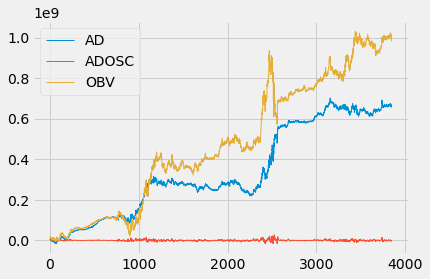

In [22]:
dataset[['AD','ADOSC','OBV']].plot(linewidth=1)

### 波动率指标函数

In [23]:
dataset['natr'] = ta.NATR(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),timeperiod=14)
dataset['atr'] = ta.ATR(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),timeperiod=14)
dataset['TRANGE'] = ta.TRANGE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,mfi,minus_di,minus_dm,mom,AD,ADOSC,OBV,natr,atr,TRANGE
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,NaN,NaN,NaN,NaN,3.174356e+06,NaN,1.269743e+07,NaN,NaN,NaN
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,NaN,NaN,NaN,NaN,7.690499e+06,NaN,1.269743e+07,NaN,NaN,0.008
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,NaN,NaN,NaN,NaN,6.846397e+06,NaN,1.776203e+07,NaN,NaN,0.012
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,NaN,NaN,NaN,NaN,5.802146e+06,NaN,1.588238e+07,NaN,NaN,0.010
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,NaN,NaN,NaN,NaN,4.761674e+06,NaN,1.380144e+07,NaN,NaN,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,45.981280,15.432946,0.119910,0.002,6.597106e+08,-2.484412e+06,9.940283e+08,1.599364,0.055498,0.055
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,41.560586,18.084189,0.137345,-0.041,6.592281e+08,-3.111421e+06,9.894450e+08,1.569678,0.054248,0.038
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,33.960221,20.959879,0.163534,-0.128,6.575701e+08,-3.612632e+06,9.840383e+08,1.625266,0.055730,0.075
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,39.301190,19.941467,0.151853,-0.012,6.597613e+08,-2.792025e+06,9.870724e+08,1.571583,0.054392,0.037


<AxesSubplot:>

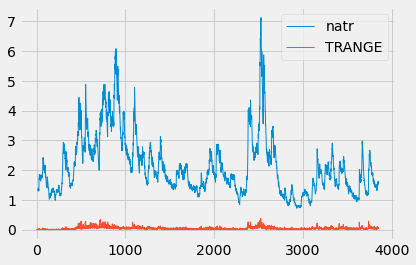

In [24]:
dataset[['natr','TRANGE']].plot(linewidth=1)

### 价格指标

In [25]:
dataset['avgprice'] = ta.AVGPRICE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['medprice'] = ta.MEDPRICE(dataset.high.to_numpy(),dataset.low.to_numpy())
dataset['typprice'] = ta.TYPPRICE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['wclprice'] = ta.WCLPRICE(dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,AD,ADOSC,OBV,natr,atr,TRANGE,avgprice,medprice,typprice,wclprice
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,3.174356e+06,NaN,1.269743e+07,NaN,NaN,NaN,0.87625,0.8740,0.874667,0.87500
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,7.690499e+06,NaN,1.269743e+07,NaN,NaN,0.008,0.87400,0.8720,0.873333,0.87400
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,6.846397e+06,NaN,1.776203e+07,NaN,NaN,0.012,0.87975,0.8810,0.880667,0.88050
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,5.802146e+06,NaN,1.588238e+07,NaN,NaN,0.010,0.87475,0.8745,0.873667,0.87325
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,4.761674e+06,NaN,1.380144e+07,NaN,NaN,0.008,0.86875,0.8690,0.868333,0.86800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,6.597106e+08,-2.484412e+06,9.940283e+08,1.599364,0.055498,0.055,3.49050,3.4925,3.485000,3.48125
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,6.592281e+08,-3.111421e+06,9.894450e+08,1.569678,0.054248,0.038,3.45825,3.4580,3.457333,3.45700
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,6.575701e+08,-3.612632e+06,9.840383e+08,1.625266,0.055730,0.075,3.44475,3.4405,3.436667,3.43475
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,6.597613e+08,-2.792025e+06,9.870724e+08,1.571583,0.054392,0.037,3.44800,3.4480,3.452333,3.45450


<AxesSubplot:>

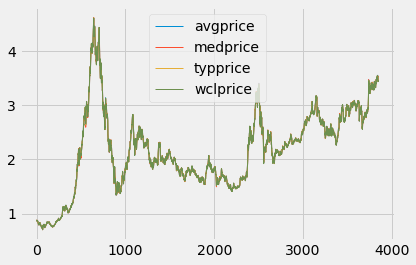

In [26]:
dataset[['avgprice','medprice','typprice','wclprice']].plot(linewidth=1)

### 周期性指标

In [27]:
dataset['ht_dcperiod'] = ta.HT_DCPERIOD(dataset.close.to_numpy())
dataset['ht_dcphase'] = ta.HT_DCPHASE(dataset.close.to_numpy())
inphase,quadrature = ta.HT_PHASOR(dataset.close.to_numpy())
dataset['inphase'] = inphase
dataset['quadrature'] = quadrature
dataset['sine'],dataset['leadsine'] = ta.HT_SINE(dataset.close.to_numpy())
dataset['ht_trendmode'] = ta.HT_TRENDMODE(dataset.close.to_numpy())
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,medprice,typprice,wclprice,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,leadsine,ht_trendmode
0,510050.SH,20050223,0.887,0.881,0.882,0.866,0.876,-0.011,-1.2401,12697425.42,...,0.8740,0.874667,0.87500,NaN,NaN,NaN,NaN,NaN,NaN,0
1,510050.SH,20050224,0.876,0.876,0.876,0.868,0.876,0.000,0.0000,4516142.23,...,0.8720,0.873333,0.87400,NaN,NaN,NaN,NaN,NaN,NaN,0
2,510050.SH,20050225,0.876,0.877,0.887,0.875,0.880,0.004,0.4566,5064606.95,...,0.8810,0.880667,0.88050,NaN,NaN,NaN,NaN,NaN,NaN,0
3,510050.SH,20050228,0.880,0.878,0.879,0.870,0.872,-0.008,-0.9091,1879651.93,...,0.8745,0.873667,0.87325,NaN,NaN,NaN,NaN,NaN,NaN,0
4,510050.SH,20050301,0.872,0.870,0.873,0.865,0.867,-0.005,-0.5734,2080944.56,...,0.8690,0.868333,0.86800,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,3.4925,3.485000,3.48125,16.264338,221.291859,0.040298,-0.013870,-0.659895,-0.997906,1
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,3.4580,3.457333,3.45700,16.711002,233.339014,0.013658,-0.042709,-0.802182,-0.989427,1
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,3.4405,3.436667,3.43475,17.260247,251.265708,0.009857,-0.042034,-0.947018,-0.896751,0
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,3.4480,3.452333,3.45450,17.950386,263.933425,-0.013482,-0.074490,-0.994400,-0.777877,0


<AxesSubplot:>

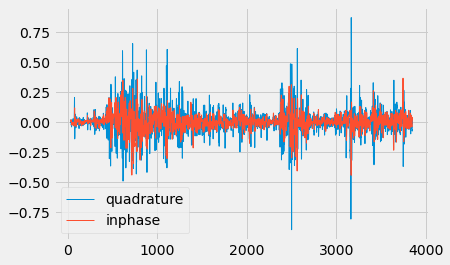

In [28]:

dataset[['quadrature','inphase']].plot(linewidth=1)


### 股市特定规律形态识别

In [29]:
dataset['cdl2crows'] = ta.CDL2CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3blackccrows'] = ta.CDL3BLACKCROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3inside'] = ta.CDL3INSIDE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3linestrike'] = ta.CDL3LINESTRIKE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3outside'] = ta.CDL3OUTSIDE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3starsinsouth'] = ta.CDL3STARSINSOUTH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdl3whitesoldiers'] = ta.CDL3WHITESOLDIERS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlabandonedbaby'] = ta.CDLABANDONEDBABY(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdladvanceblock'] = ta.CDLADVANCEBLOCK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlbelthold'] = ta.CDLBELTHOLD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlbreakaway'] = ta.CDLBREAKAWAY(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlclosingmarubozu'] = ta.CDLCLOSINGMARUBOZU(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlconecalbabyswall'] = ta.CDLCONCEALBABYSWALL(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlcounterattack'] = ta.CDLCOUNTERATTACK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldarkcloudcover'] = ta.CDLDARKCLOUDCOVER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldoji'] = ta.CDLDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldojistar'] = ta.CDLDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdldragonflydoji'] = ta.CDLDRAGONFLYDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlengulfing'] = ta.CDLENGULFING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdleveningdojistar'] = ta.CDLEVENINGDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),penetration=0)
dataset['cdleveningstar'] = ta.CDLEVENINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy(),penetration=0)
dataset['cdlgravestonedoji'] = ta.CDLGRAVESTONEDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhammer'] = ta.CDLHAMMER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhangingman'] = ta.CDLHANGINGMAN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlharami'] = ta.CDLHARAMI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlharamicross'] = ta.CDLHARAMICROSS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhighwave'] = ta.CDLHIGHWAVE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhikkake'] = ta.CDLHIKKAKE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhikkakemod'] = ta.CDLHIKKAKEMOD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlhomingpigeon'] = ta.CDLHOMINGPIGEON(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlidentical3crows'] = ta.CDLIDENTICAL3CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlinneck'] = ta.CDLINNECK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlinvertedhammer'] = ta.CDLINVERTEDHAMMER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlkicking'] = ta.CDLKICKING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlkickingbylength'] = ta.CDLKICKINGBYLENGTH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlladderbottom'] = ta.CDLLADDERBOTTOM(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdllongleggeddoji'] = ta.CDLLONGLEGGEDDOJI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdllongline'] = ta.CDLLONGLINE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmarubozu'] = ta.CDLMARUBOZU(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmatchinglow'] = ta.CDLMATCHINGLOW(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmathold'] = ta.CDLMATHOLD(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmorningdojistar'] = ta.CDLMORNINGDOJISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlmorningstar'] = ta.CDLMORNINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlonneck'] = ta.CDLONNECK(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlpiercing'] = ta.CDLPIERCING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlrickshawman'] = ta.CDLRICKSHAWMAN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlrisefall3methods'] = ta.CDLRISEFALL3METHODS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlseparatinglines'] = ta.CDLSEPARATINGLINES(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlshootingshar'] = ta.CDLSHOOTINGSTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlshortline'] = ta.CDLSHORTLINE(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlspinningtop'] = ta.CDLSPINNINGTOP(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlstalledpattern'] = ta.CDLSTALLEDPATTERN(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlsticksandwich'] = ta.CDLSTICKSANDWICH(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltakuri'] = ta.CDLTAKURI(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltasukigap'] = ta.CDLTASUKIGAP(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlthrusting'] = ta.CDLTHRUSTING(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdltristar'] = ta.CDLTRISTAR(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlunique3river'] = ta.CDLUNIQUE3RIVER(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlupsidegap2crows'] = ta.CDLUPSIDEGAP2CROWS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())
dataset['cdlxsidegap3methods'] = ta.CDLXSIDEGAP3METHODS(dataset.open.to_numpy(),dataset.high.to_numpy(),dataset.low.to_numpy(),dataset.close.to_numpy())

array([[<AxesSubplot:title={'center':'cdlspinningtop'}>,
        <AxesSubplot:title={'center':'cdlthrusting'}>]], dtype=object)

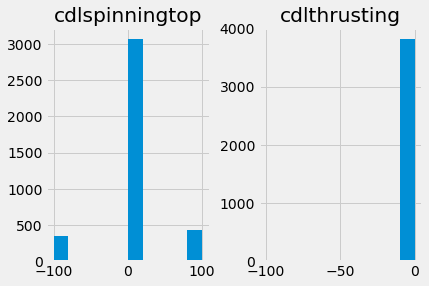

In [30]:
dataset[['cdlspinningtop','cdlthrusting']].hist()

In [31]:
dataset = dataset.dropna(how='any')
dataset

,ts_code,trade_date,pre_close,open,high,low,close,change,pct_chg,vol,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
174,510050.SH,20051108,0.766,0.765,0.774,0.763,0.772,0.006,0.7833,877776.25,...,0,0,0,0,0,0,0,0,0,0
175,510050.SH,20051109,0.772,0.770,0.774,0.765,0.766,-0.006,-0.7772,5398117.36,...,0,0,0,0,0,0,0,0,0,0
176,510050.SH,20051110,0.766,0.764,0.768,0.754,0.755,-0.011,-1.4360,4710164.68,...,0,0,0,0,0,0,0,0,0,0
177,510050.SH,20051111,0.755,0.753,0.759,0.752,0.756,0.001,0.1325,719269.42,...,0,0,0,0,0,-100,0,0,0,0
178,510050.SH,20051114,0.756,0.755,0.757,0.752,0.752,-0.004,-0.5291,553013.59,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3843,510050.SH,20201209,3.499,3.507,3.520,3.465,3.470,-0.029,-0.8288,5122861.03,...,0,0,0,0,0,0,0,0,0,0
3844,510050.SH,20201210,3.470,3.461,3.477,3.439,3.456,-0.014,-0.4035,4583334.10,...,-100,0,0,0,0,0,0,0,0,0
3845,510050.SH,20201211,3.456,3.469,3.478,3.403,3.429,-0.027,-0.7813,5406706.55,...,0,0,0,0,0,0,0,0,0,0
3846,510050.SH,20201214,3.429,3.435,3.466,3.430,3.461,0.032,0.9332,3034085.37,...,0,0,0,0,0,0,0,0,0,0


## 预测close：

In [32]:
features_close = dataset.drop(labels = ['label','ts_code','trade_date'], axis = 1)
label_close = dataset.close

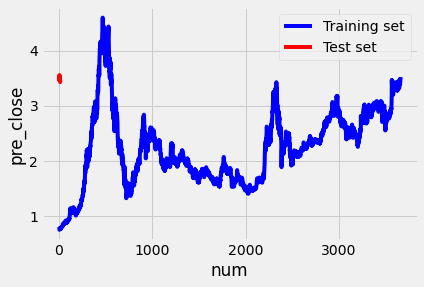

In [168]:
train_num = 3659
training_set = features_close[:train_num].values.astype('float')
test_set = features_close[train_num:].values.astype('float')
train_label = label_close[:train_num].values.astype('float')
test_label = label_close[train_num:].values.astype('float')

plt.plot(training_set[:,0], color='blue', label='Training set')
plt.plot(test_set[:,0], color='red', label='Test set')
plt.xlabel('num')
plt.ylabel('pre_close')
plt.legend()
plt.show()

In [169]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

time_step = 5
X_train = []
y_train = []
for i in range(time_step, len(training_set)):
    X_train.append(training_set_scaled[(i-time_step):i,:])
    y_train.append(train_label[i])
X_train, y_train = np.array(X_train), np.array(y_train)


In [170]:
# LSTM
regressor = Sequential()
# firt LSTM layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))
# second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# output layer
regressor.add(Dense(units=1))
# compile the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressor.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
115/115 [==============================] - 6s 8ms/step - loss: 0.9240
Epoch 2/60
115/115 [==============================] - 1s 7ms/step - loss: 0.1341
Epoch 3/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0958
Epoch 4/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0847
Epoch 5/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0707
Epoch 6/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0611
Epoch 7/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0646
Epoch 8/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0621
Epoch 9/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0569
Epoch 10/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0508
Epoch 11/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0502
Epoch 12/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0443
Epoch 13/60
115/115 [====

In [171]:
# scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc.fit_transform(test_set)
time_step = 5
# create a data structure with 60 timesteps and 1 output, 
# so for each element of training set, there are 60 previous training set elements
X_test = [] # feature
y_test = [] # lable
# training_set length is 7056, it is the total days between 1990-01-01 and 2017-12-29, also is the rows in the csv file
for i in range(time_step, len(test_set)):
    X_test.append(test_set_scaled[(i-time_step):i,:])
    y_test.append(test_label[i])
X_test, y_test = np.array(X_test), np.array(y_test)

In [172]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],))
LSTM_predicted_stock_price_close = regressor.predict(X_test)
#LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

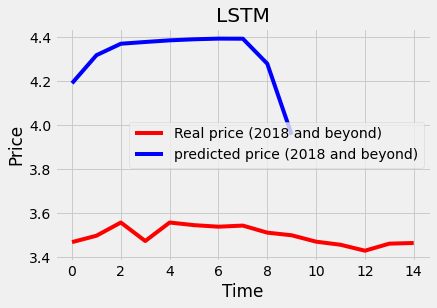

In [173]:
plt.plot(test_label, color='red', label='Real price (2018 and beyond)')
plt.plot(LSTM_predicted_stock_price_close, color='blue', label='predicted price (2018 and beyond)')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [196]:
label = []
for i in range(len(LSTM_predicted_stock_price_close)):
    if i == 0:
        label.append(1)
    else:
        label.append(int(LSTM_predicted_stock_price_close[i-1]<LSTM_predicted_stock_price_close[i]))
label[0:5]

[1, 1, 1, 1, 1]

In [197]:
label2 = []
for i in range(len(test_label)):
    if i == 0:
        label2.append(1)
    else:
        label2.append(int(test_label[i-1]<test_label[i]))
label2[0:5]

[1, 1, 1, 0, 1]

In [198]:
sum_ = 0
for i in range(len(label)):
    if label2[i+3] == label[i]:
        sum_+=1
sum_/len(label)

0.5

### 使用GRU进行预测

In [177]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
# compile the RNN
regressorGRU.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressorGRU.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
115/115 [==============================] - 5s 8ms/step - loss: 0.5503
Epoch 2/60
115/115 [==============================] - 1s 7ms/step - loss: 0.1554
Epoch 3/60
115/115 [==============================] - 1s 7ms/step - loss: 0.1123
Epoch 4/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0835
Epoch 5/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0758
Epoch 6/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0676
Epoch 7/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0679
Epoch 8/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0631
Epoch 9/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0564
Epoch 10/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0610
Epoch 11/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0479
Epoch 12/60
115/115 [==============================] - 1s 7ms/step - loss: 0.0478
Epoch 13/60
115/115 [====

In [178]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],))
LSTM_predicted_stock_price_close_GRU = regressorGRU.predict(X_test)
#LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

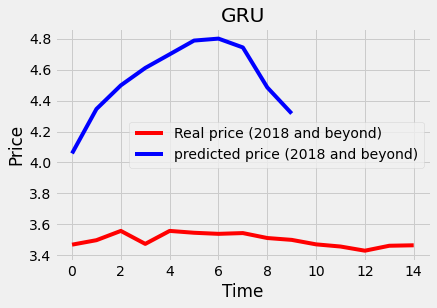

In [179]:
plt.plot(test_label, color='red', label='Real price (2018 and beyond)')
plt.plot(LSTM_predicted_stock_price_close_GRU, color='blue', label='predicted price (2018 and beyond)')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [180]:
len(test_label),len(LSTM_predicted_stock_price_close_GRU)

(15, 10)

In [181]:
test_label[0:5]

array([3.468, 3.497, 3.557, 3.473, 3.557])

In [182]:
LSTM_predicted_stock_price_close_GRU[0:5]

array([[4.05826  ],
       [4.3455048],
       [4.498593 ],
       [4.61107  ],
       [4.6993866]], dtype=float32)

In [183]:
label = []
for i in range(len(LSTM_predicted_stock_price_close_GRU)):
    if i == 0:
        label.append(1)
    else:
        label.append(int(LSTM_predicted_stock_price_close_GRU[i-1]<LSTM_predicted_stock_price_close_GRU[i]))
label[0:5]

[1, 1, 1, 1, 1]

In [184]:
label2 = []
for i in range(len(test_label)):
    if i == 0:
        label2.append(1)
    else:
        label2.append(int(test_label[i-1]<test_label[i]))
label2[0:5]

[1, 1, 1, 0, 1]

In [185]:
sum_ = 0
for i in range(len(label)):
    if label2[i+3] == label[i]:
        sum_+=1
sum_/len(label)

0.5

In [186]:
# BiLSTM
regressorBiLSTM = Sequential()
# firt LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1],X_train.shape[2]), merge_mode='concat'))
regressorBiLSTM.add(Dropout(0.2))
# second LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# third LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# fourth LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50)))
regressorBiLSTM.add(Dropout(0.2))
# output layer
regressorBiLSTM.add(Dense(units=1))
# compile the RNN
regressorBiLSTM.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressorBiLSTM.fit(X_train, y_train, epochs=60, batch_size=32)

Epoch 1/60
115/115 [==============================] - 8s 10ms/step - loss: 0.6803
Epoch 2/60
115/115 [==============================] - 1s 10ms/step - loss: 0.1218
Epoch 3/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0942
Epoch 4/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0678
Epoch 5/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0569
Epoch 6/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0540
Epoch 7/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0475
Epoch 8/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0421
Epoch 9/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0423
Epoch 10/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0413
Epoch 11/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0374
Epoch 12/60
115/115 [==============================] - 1s 10ms/step - loss: 0.0377
Epoch 13/60
1

In [187]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],))
BiLSTM_predicted_stock_price_close = regressorBiLSTM.predict(X_test)
#LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

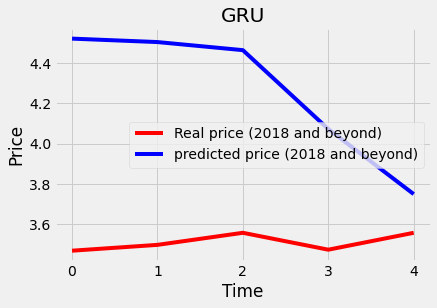

In [188]:
plt.plot(test_label[0:5], color='red', label='Real price (2018 and beyond)')
plt.plot(BiLSTM_predicted_stock_price_close[5:10], color='blue', label='predicted price (2018 and beyond)')
plt.title('GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [189]:
label = []
for i in range(len(BiLSTM_predicted_stock_price_close)):
    label.append(int(BiLSTM_predicted_stock_price_close[i-1]<BiLSTM_predicted_stock_price_close[i]))
label[0:5]

[1, 1, 1, 1, 1]

In [190]:
label2 = []
for i in range(1,len(test_label)):
    label2.append(int(test_label[i-1]<test_label[i]))
label2[0:5]

[1, 1, 0, 1, 0]

In [195]:
sum_ = 0
for i in range(len(label)):
    if label2[i+3] == label[i]:
        sum_+=1
sum_/len(label)

0.6

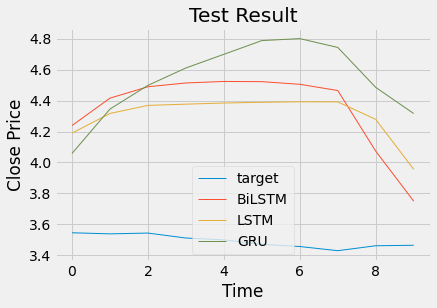

In [199]:
plt.plot(test_label[5:], linewidth=1, label='target')
plt.plot(BiLSTM_predicted_stock_price_close, linewidth=1, label='BiLSTM')
plt.plot(LSTM_predicted_stock_price_close, linewidth=1, label='LSTM')
plt.plot(LSTM_predicted_stock_price_close_GRU,linewidth=1, label='GRU')
plt.title('Test Result')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()